Notebook Logistic Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Logistic Regression toepassen op de data voor classificatie

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/arifmia/heart-attack-risk-dataset


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- missing data oplossen 
- incorrect types controleren
- Numerische waarde standardizeren
- Categorische varaiabelen processen
- Feature engineering
- select features for modelling
- unbalance van de features corrigeren met SMOTE
- modeling met Logistic Regression, Decision Tree Regression en Random Forrest Regression
- modeling met Hyperparameter tuning met GridSearchCV
- modeling met Optuna voor Hyperparameter tuning

In [108]:
# import van de diverse modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import plot_importance

from sklearn.metrics import classification_report
from sklearn.metrics import  confusion_matrix, accuracy_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings


plot_graphs = True

In [109]:
# extra code overal gebruikt

# extra code – code to save the figures as high-res PNGs for the book
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_overzicht_kolommen(df_plot, num_columns = 3, figuur_naam = 'Overzicht kolommen', bins = 50):    
    num_plots = len(df_plot.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df_plot.columns):
        df_plot[column].hist(bins, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()    
    if plot_graphs:
        save_fig(figuur_naam)
        plt.show()


def plot_histogram_old(df_hist, column, bins = 50, figuur_naam = 'Overzicht kolommen'):
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=14)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    # plt.hist(df_hist[column], color='blue', alpha=0.7)
    plt.title('Histogram van Heart Rate')
    plt.xlabel('Heart Rate')
    plt.ylabel('Frequentie')
    if plot_graphs:
        df_hist[column].hist(bins, figsize=(12, 8))
        save_fig(figuur_naam)  # extra code
    plt.show()



def plot_histogram(dataframe, column, bins=20, color='blue', title='', xlabel='', ylabel='Frequentie', filenaam = "Histogram"):
    """
    Deze functie plot een histogram van een gespecificeerde kolom uit een pandas DataFrame.
    
    Parameters:
        dataframe (pd.DataFrame): Het DataFrame dat de data bevat.
        column (str): De naam van de kolom waarvan een histogram moet worden geplot.
        bins (int): Het aantal bins (groepen) voor het histogram.
        color (str): De kleur van de histogram bars.
        title (str): De titel van de plot.
        xlabel (str): De label voor de x-as.
        ylabel (str): De label voor de y-as.
    """
    # Controleer of de kolom bestaat in het DataFrame
    if column not in dataframe.columns:
        print(f"Kolom '{column}' niet gevonden in het DataFrame.")
        return

    # Plot het histogram
    plt.hist(dataframe[column], bins=bins, color=color, alpha=0.7)
    plt.title(title if title else f'Histogram van {column}')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    if plot_graphs:
        save_fig(filenaam)
        plt.show()

In [110]:
# data inlezen van de file

df = pd.read_csv('data/heart_attack_risk_dataset.csv')

# lijst met features opgedeeld in numerisch en categorisch
df_col = ['Age', 'Gender', 'Smoking', 'Alcohol_Consumption',
       'Physical_Activity_Level', 'BMI', 'Diabetes', 'Hypertension',
       'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Family_History',
       'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar',
       'ECG_Results', 'Exercise_Induced_Angina', 'Max_Heart_Rate_Achieved',
       'Heart_Attack_Risk']

# bepaal eerst de opdeling van numerische en categorische waarden op basis van de kolommen
# 3 opties

# optie 1: op basis van het datatype in de kolome
# df_num_col = df.select_dtypes(include='number').columns
# df_cat_col = df.select_dtypes(include='object').columns


# optie 2: op basis van de voorkomens van de waarden, indien <=4 is het een categorische 
# minder goed
df_cat_col = [i for i in df.columns if df[i].nunique() <= 4]
df_num_col= [i for i in df.columns if i not in df_cat_col]

# optie 3: en dit is de manuele manier om de lijst van kolommen voor numerische en categorische waarden samen te stellen
# check in via info() en describe() 
# we gaan dit verder gebruiken
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = ['Gender', 'Smoking', 'Alcohol_Consumption', 'Physical_Activity_Level', 'Diabetes', 'Hypertension', 'Family_History', 'Stress_Level',
              'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar','ECG_Results', 'Exercise_Induced_Angina', 'Heart_Attack_Risk']
df_label_col = ['Heart_Attack_Risk'] # dit is de te voorspellen waarde
df_cat_nom_col = ['Gender', 'Physical_Activity_Level', 'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'ECG_Results', 'Heart_Attack_Risk']
df_cat_ord_col = list(set(df_cat_col) - set(df_cat_nom_col))

df_num = df[df_num_col]
df_cat = df[df_cat_col]
df_label = df[df_label_col]
df_cat_nom = df[df_cat_nom_col]
df_cat_ord = df[df_cat_ord_col]


print("df_num")
print(df_num.head())


print("df_cat")
print(df_cat.head())


print("df_cat_nom")
print(df_cat_nom.head())


print("df_cat_ord")
print(df_cat_ord.head())

print("df_label")
print(df_label.head())

df_num
   Age    BMI  Cholesterol_Level  Resting_BP  Heart_Rate  \
0   69  34.61              152.1         171          85   
1   32  22.75              166.8         126         103   
2   89  35.32              272.3         123         127   
3   78  18.23              237.7         144         125   
4   38  19.82              207.7         123         107   

   Max_Heart_Rate_Achieved  
0                      114  
1                      173  
2                      109  
3                      129  
4                      124  
df_cat
   Gender  Smoking  Alcohol_Consumption Physical_Activity_Level  Diabetes  \
0  Female        1                    0                Moderate         1   
1    Male        0                    0                Moderate         0   
2    Male        0                    1                Moderate         0   
3    Male        0                    1                Moderate         1   
4  Female        1                    0                Moderate   

In [111]:
# eerste controles van alle waarden: 
# zijn er nulwaarden?
# zitten er geen duplicates tussen?

df.head()
df.describe()
df.info()

print(df.columns)

# check op nulwaarden:
df.isnull().sum()
# ok, geen nulwaarden

df.duplicated().sum()
# ok, geen duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      50000 non-null  int64  
 1   Gender                   50000 non-null  object 
 2   Smoking                  50000 non-null  int64  
 3   Alcohol_Consumption      50000 non-null  int64  
 4   Physical_Activity_Level  50000 non-null  object 
 5   BMI                      50000 non-null  float64
 6   Diabetes                 50000 non-null  int64  
 7   Hypertension             50000 non-null  int64  
 8   Cholesterol_Level        50000 non-null  float64
 9   Resting_BP               50000 non-null  int64  
 10  Heart_Rate               50000 non-null  int64  
 11  Family_History           50000 non-null  int64  
 12  Stress_Level             50000 non-null  object 
 13  Chest_Pain_Type          50000 non-null  object 
 14  Thalassemia           

np.int64(0)

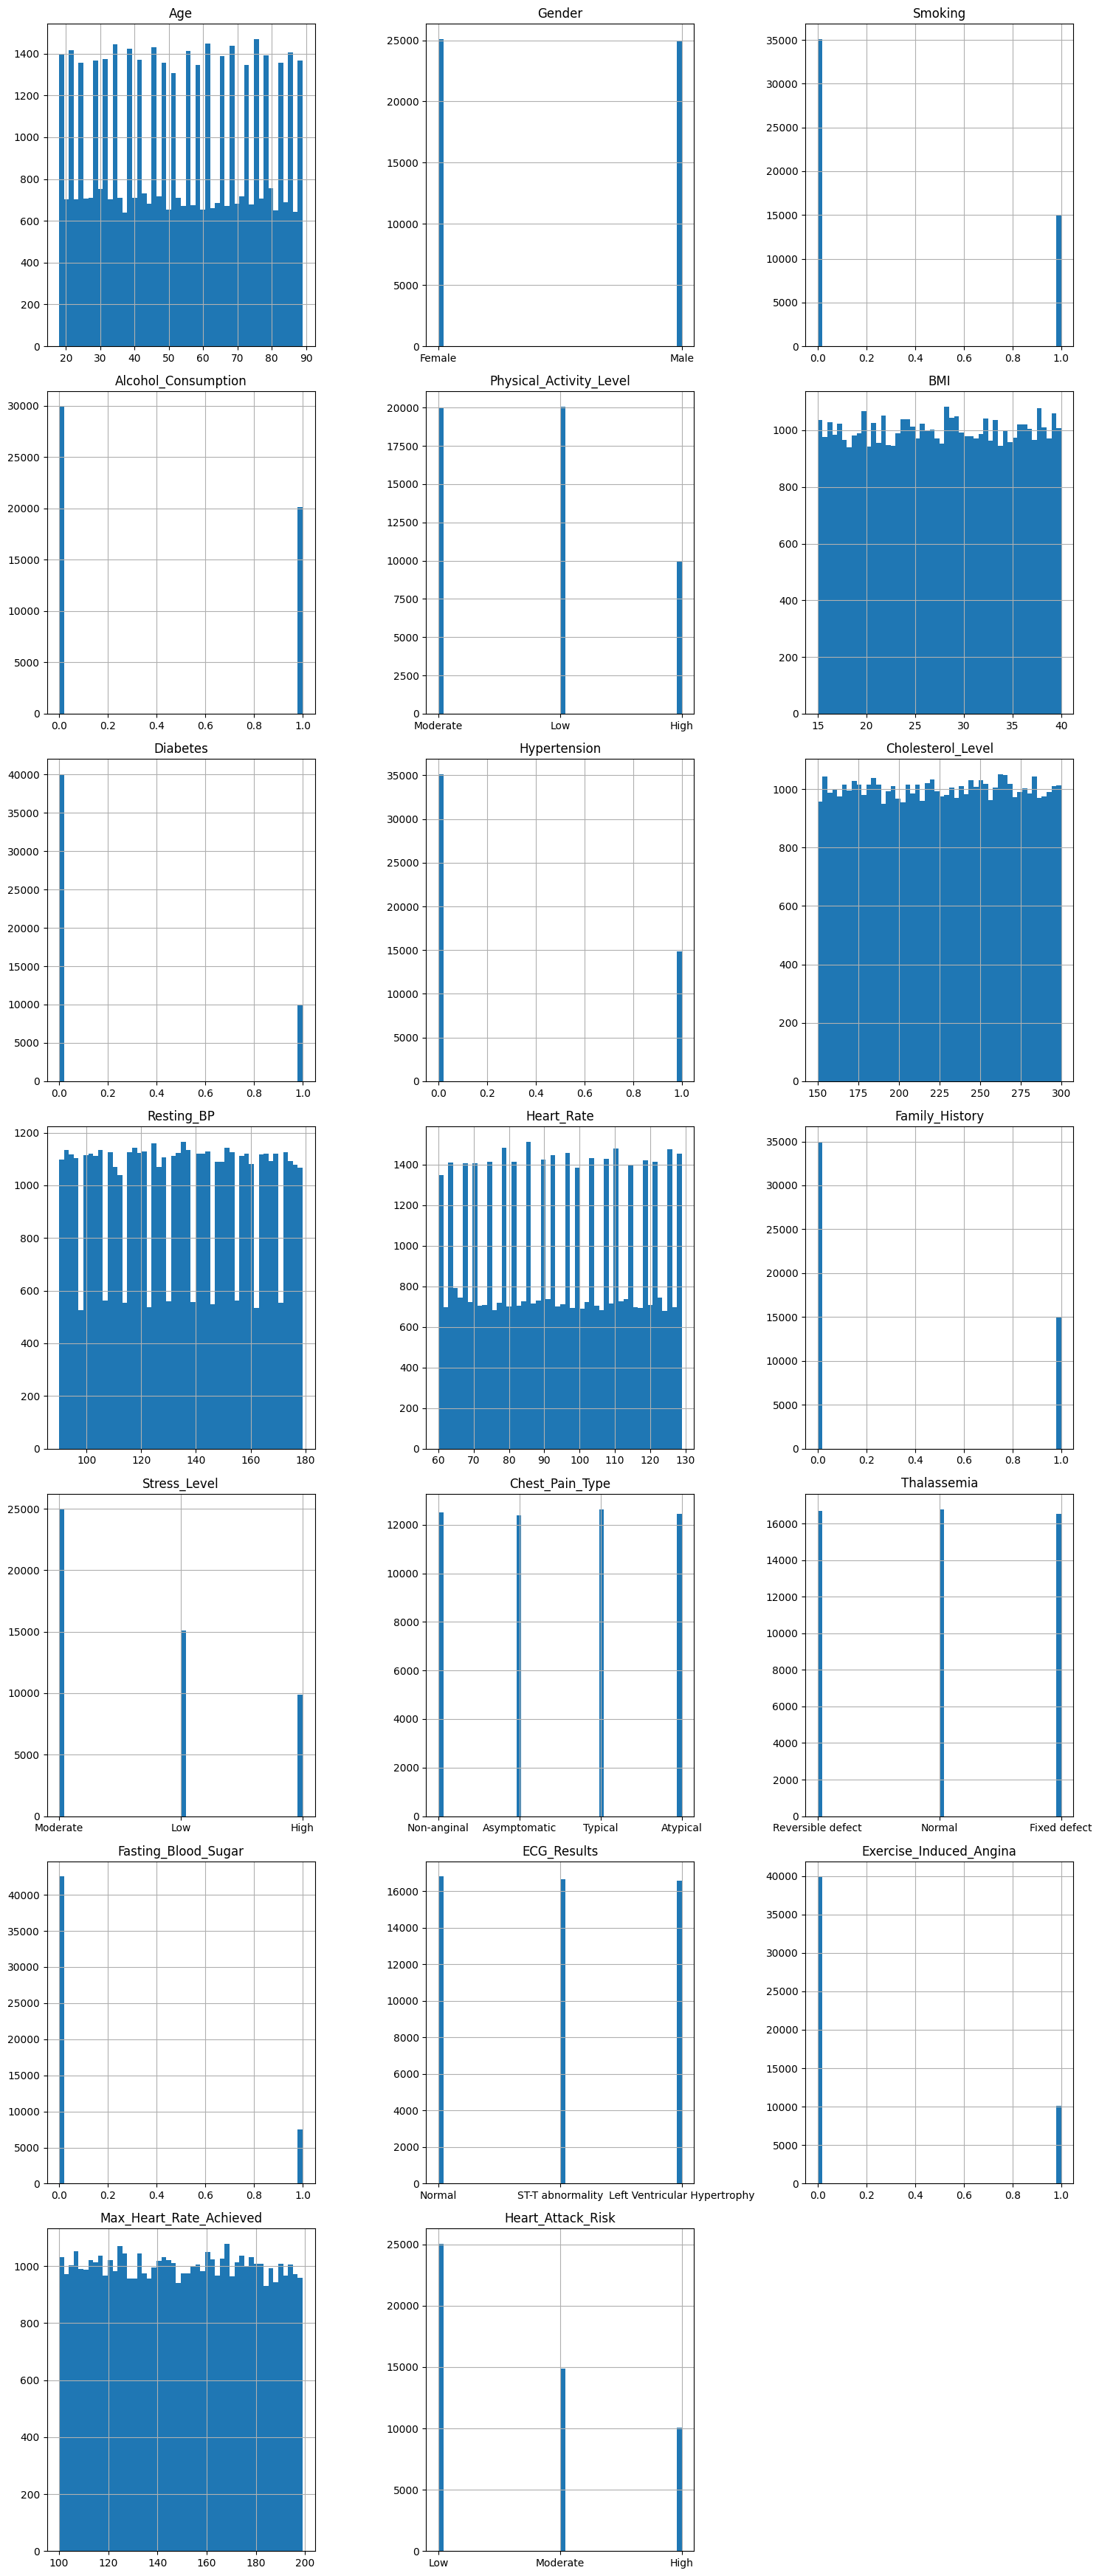

In [112]:
# We nemen eerst een snelle blik op de variabelen via een histogram plot van alle features
# We maken een algemene plot van de variabelen


if plot_graphs:
    num_columns = 3
    num_plots = len(df.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df.columns):
        df[column].hist(bins=50, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig("algemeen_overzicht_features")
    plt.show()

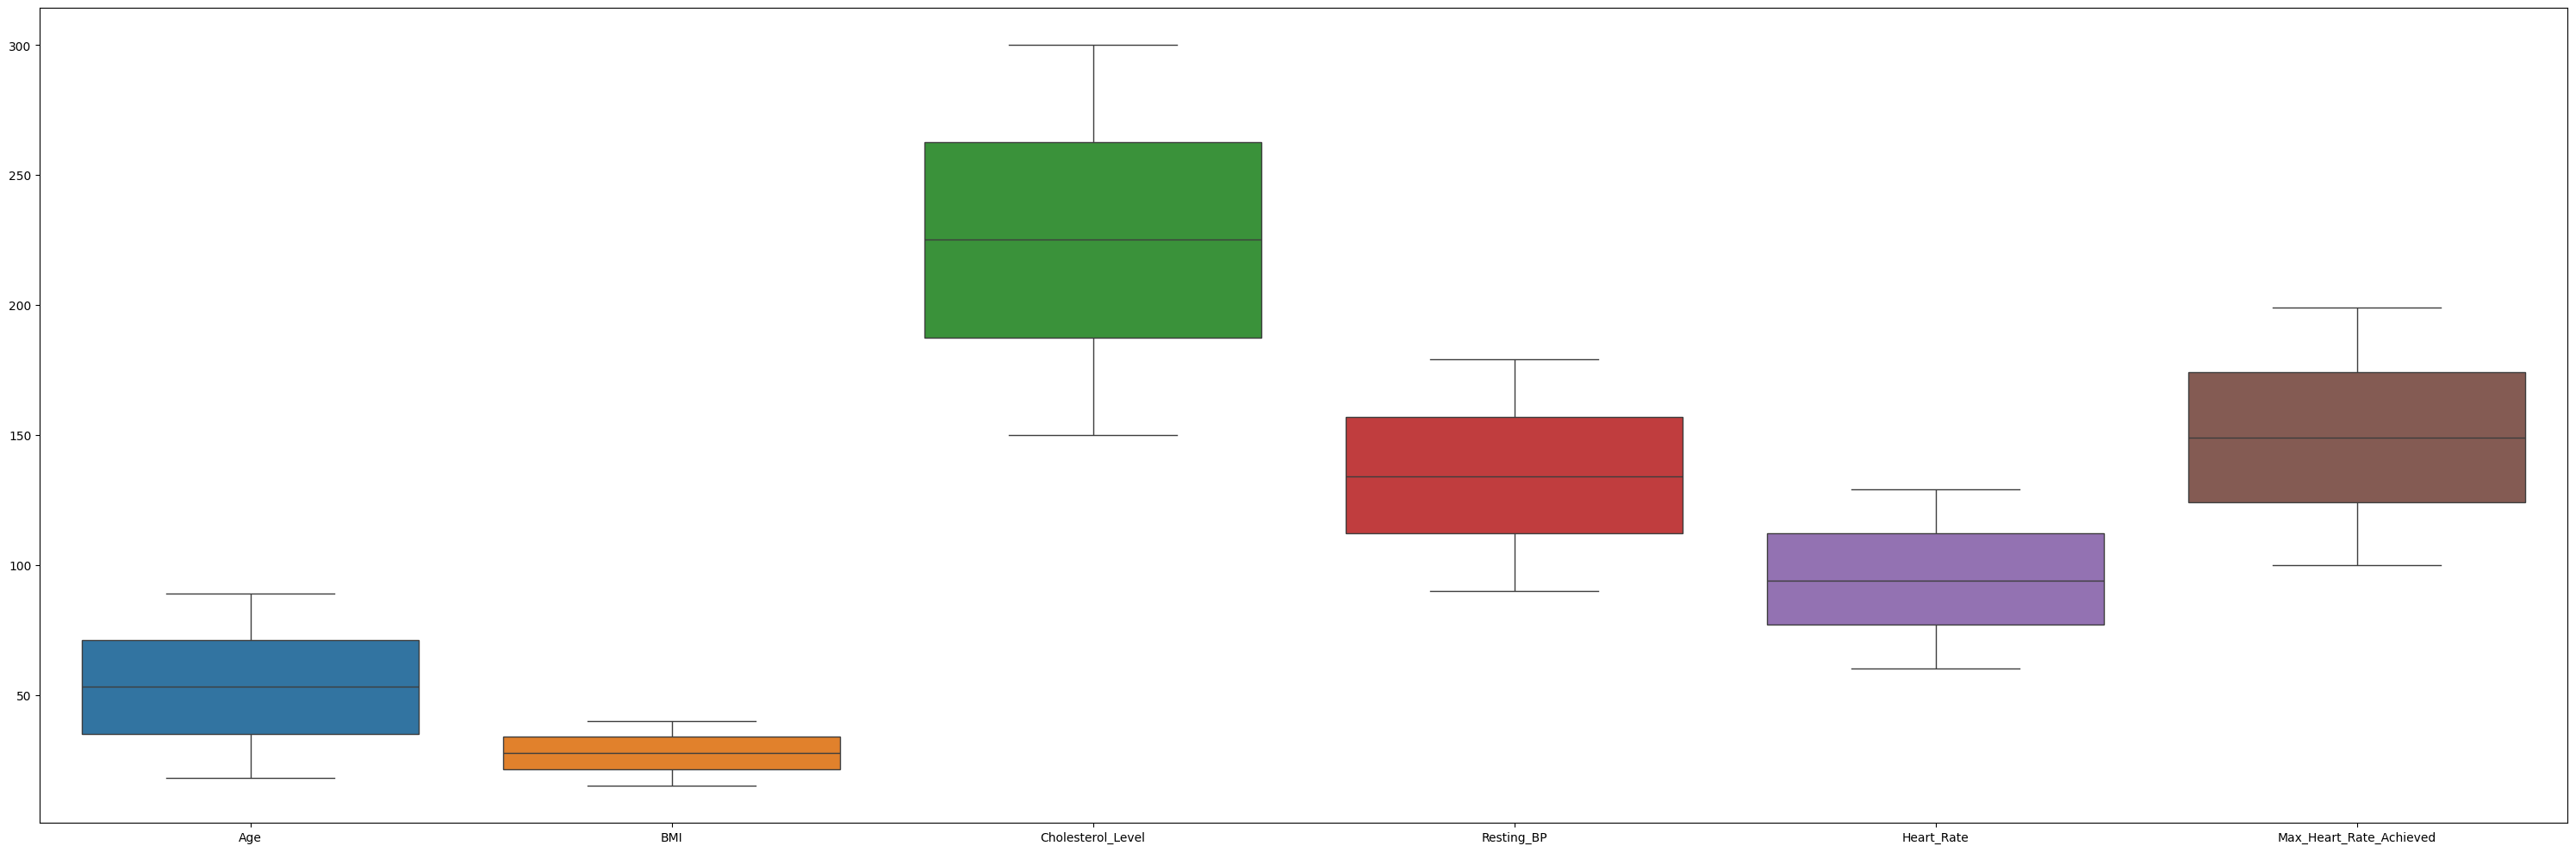

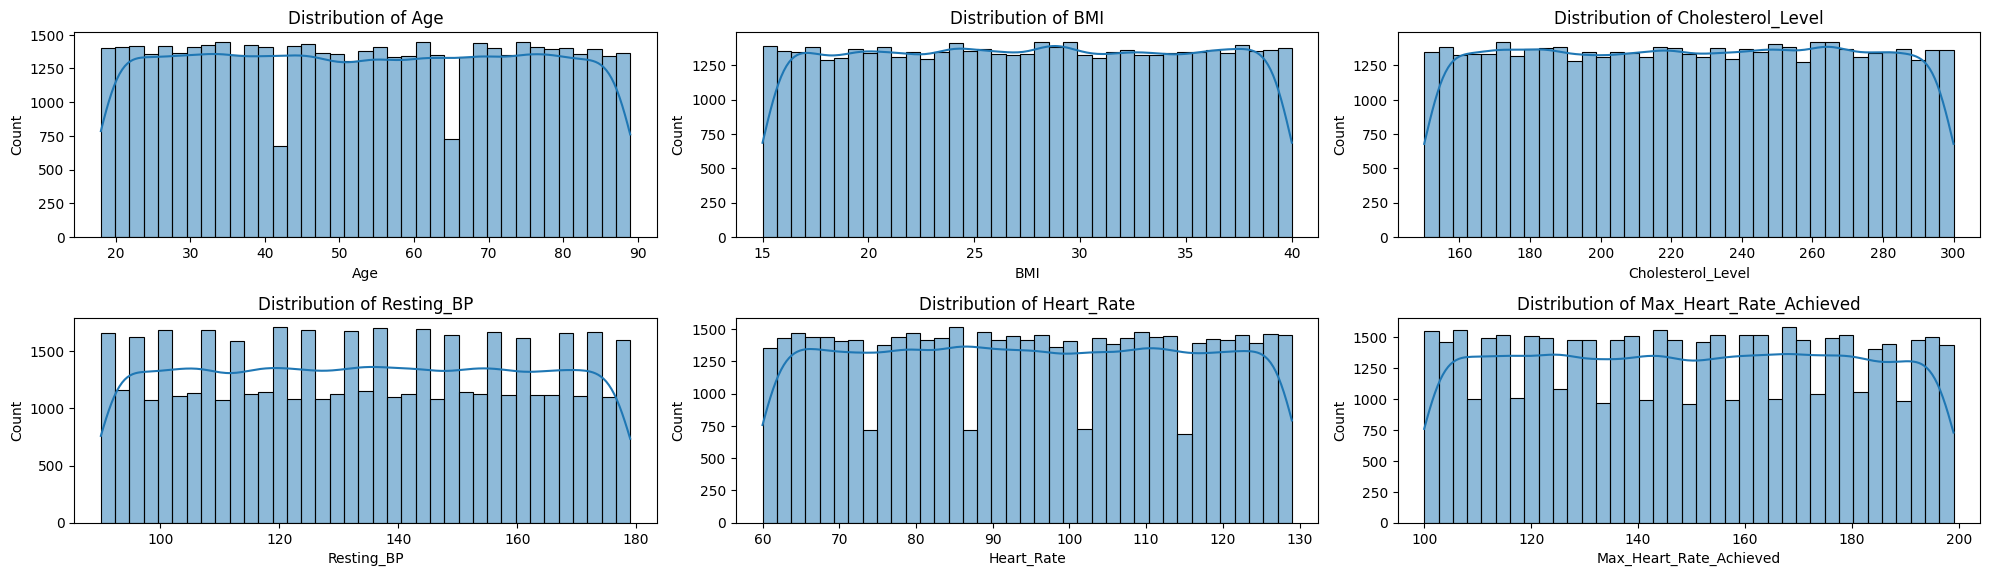

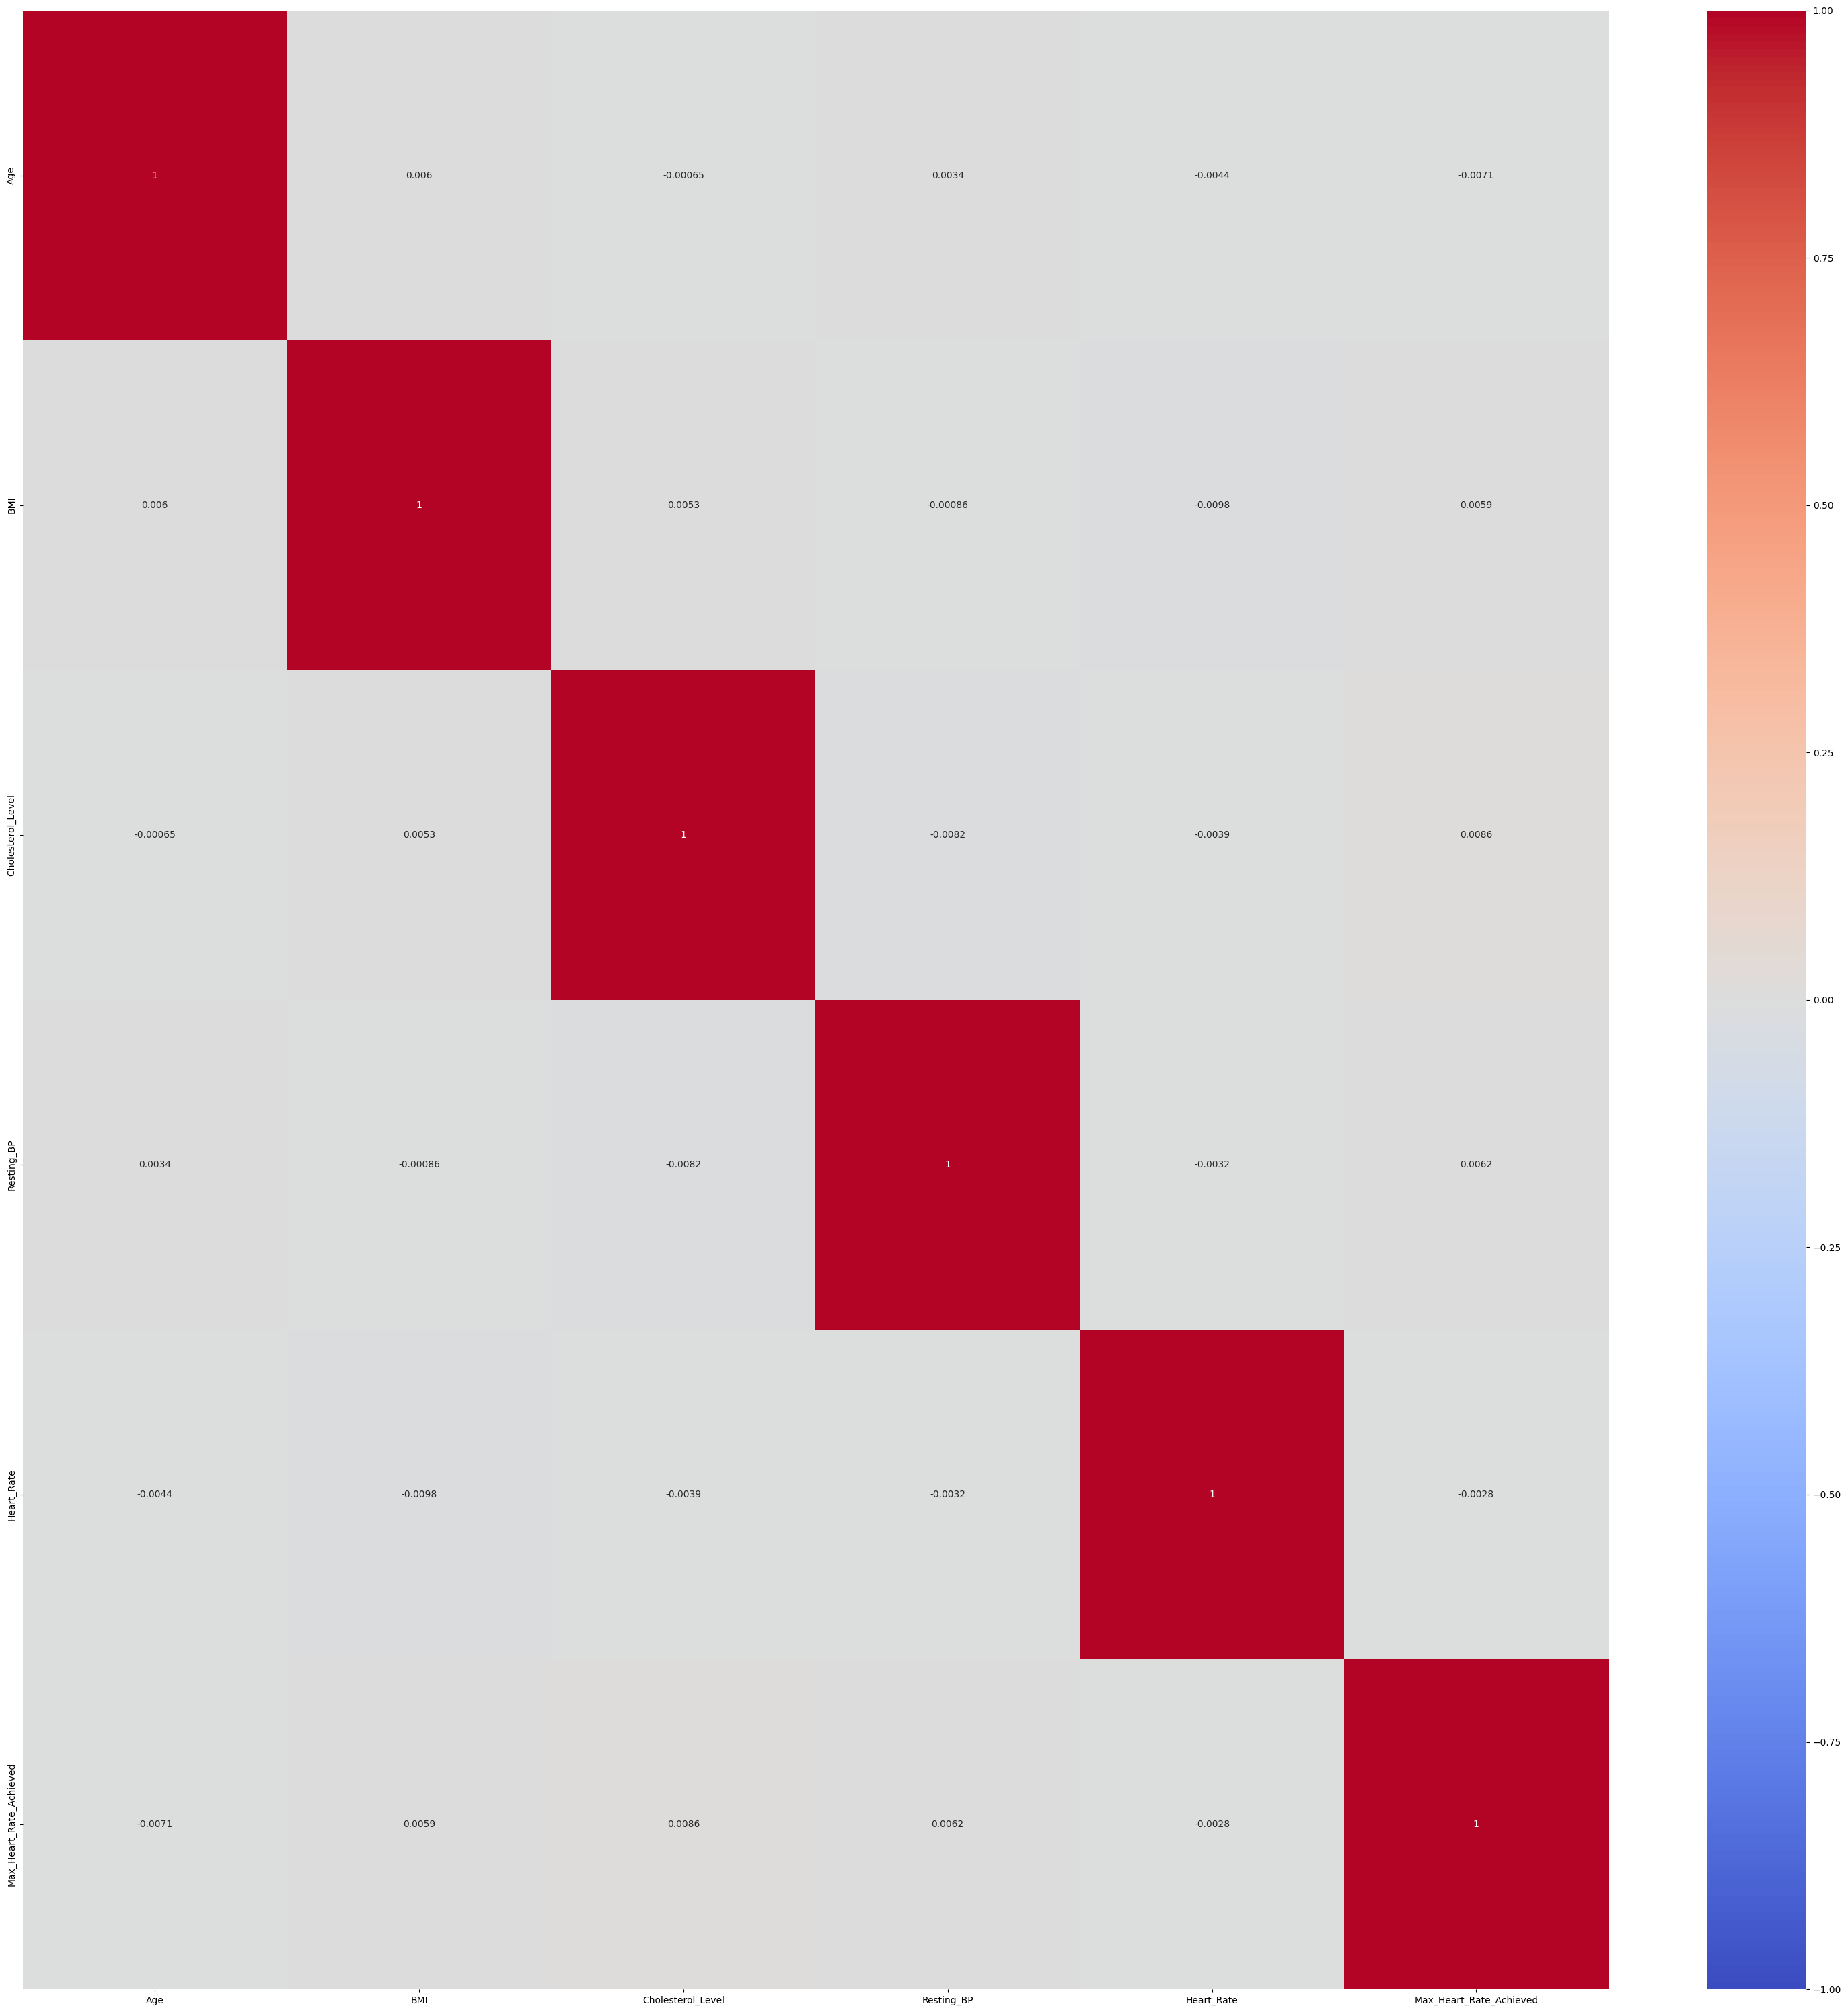

In [113]:
# analyze van de features, eerst de numerische features
# eerst een boxplot, voor de numerische waarde

# eerste een box-plot van de numerische variabelen
if plot_graphs:
    fig = plt.figure(figsize=(30,10))
    sns.boxplot(df_num)
    save_fig("Numerische features boxplot van de features")
    plt.show()
# Dit lijkt een normale verdeling. Er is hier geen log-verfijning nodig
# Er zijn ook geen outliers


# We maken nog een apart histogram van de numersiche variabelen
plt.figure(figsize=(20,14))
for i, col in enumerate(df_num_col,1):
    plt.subplot(5,3,i)
    sns.histplot(df[col], kde=True, palette='skyblue')
    plt.title(f"Distribution of {col}")
if plot_graphs:
    plt.tight_layout()
    save_fig("Numerische features histogram van de features")
    plt.show()
# Alles lijkt ook hier normaal


# Is er een correlatie tussen de numerische variabelen?
# Create corraltion heatmap
if plot_graphs:
    fig = plt.figure(figsize=(30,30))
    sns.heatmap(df_num.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
    save_fig("Numerische features: heatmap van de correlatie")
    plt.show()


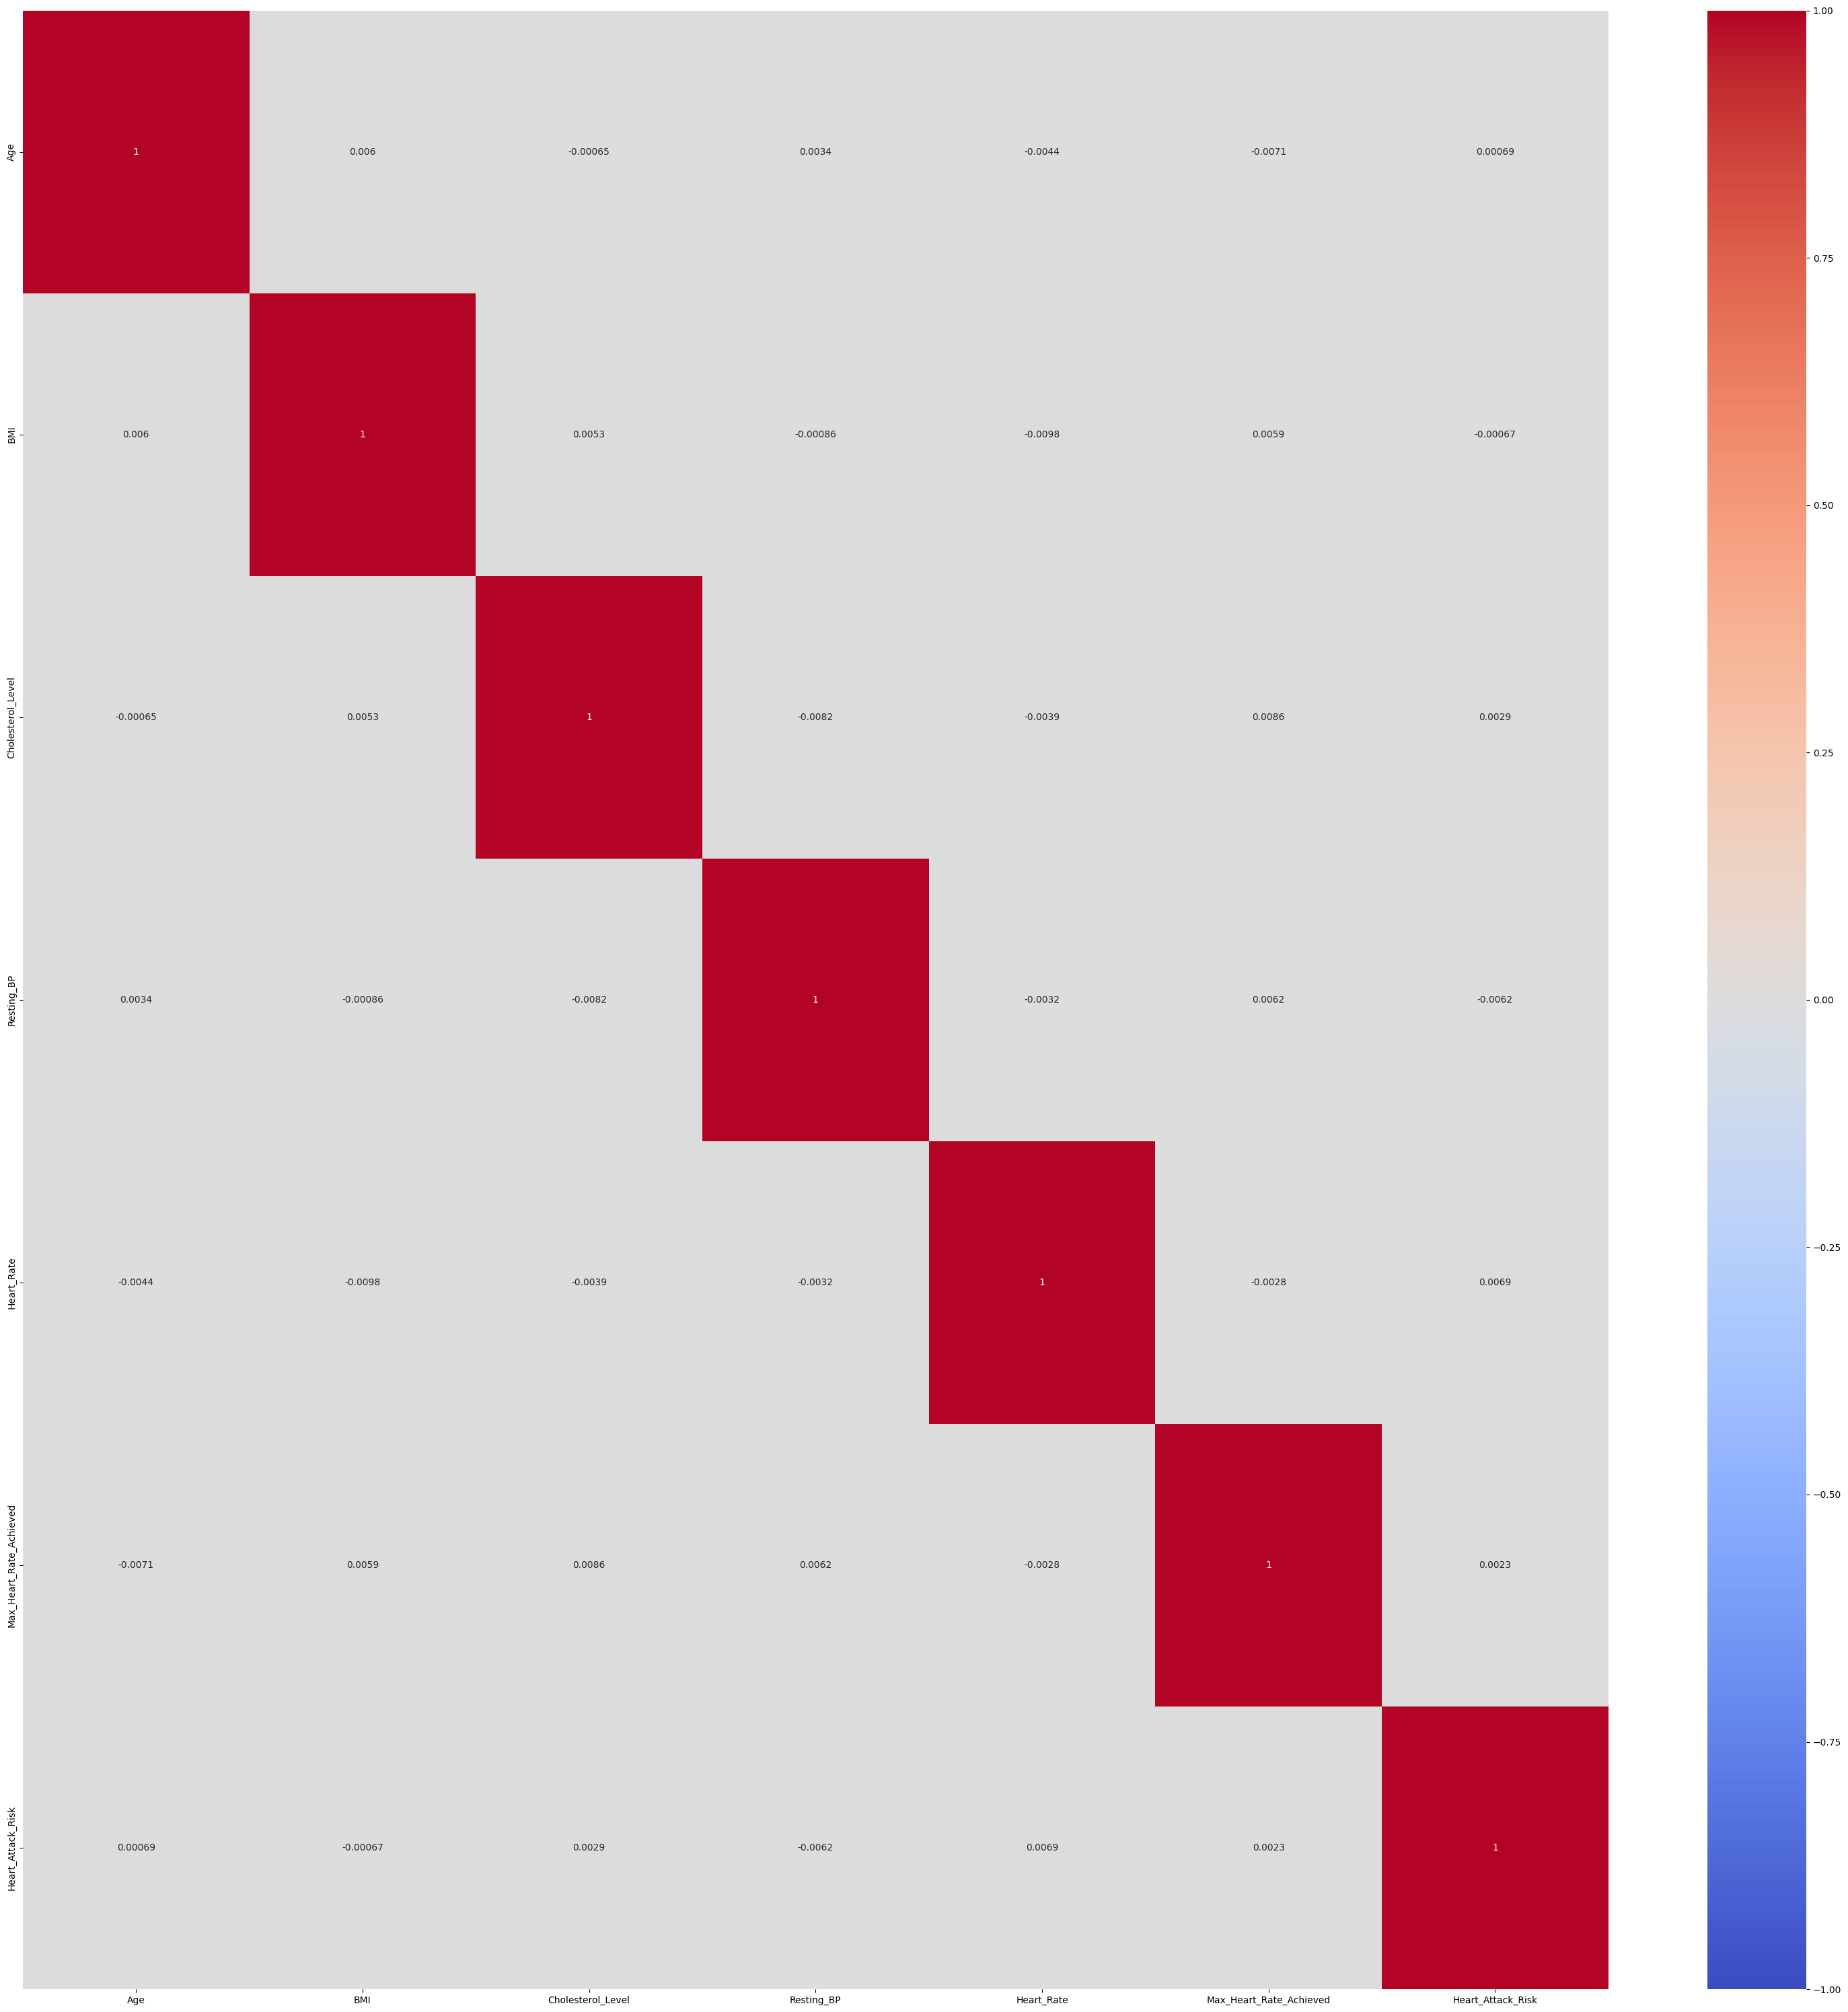

In [114]:
# is er een correlatie tussen de numerische variabelen en de target value?
# hiervoor gaan we even de target valeu mappen naar een numerische waarde
df_corr = pd.concat([df_num, df[df_label_col]], axis=1)
df_corr.Heart_Attack_Risk = df_corr.Heart_Attack_Risk.map({'Low':1,'Moderate':2,'High':3})
df_corr.head()

if plot_graphs:
    fig = plt.figure(figsize=(30,30))
    sns.heatmap(df_corr.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
    save_fig("Numerische features: heatmap van de correlatie")
    plt.show()


# mmm, precies toch niet zo heel veel...


In [115]:
# analyze van de categorische features

print(df_cat.head())
print(df_cat.describe())

   Gender  Smoking  Alcohol_Consumption Physical_Activity_Level  Diabetes  \
0  Female        1                    0                Moderate         1   
1    Male        0                    0                Moderate         0   
2    Male        0                    1                Moderate         0   
3    Male        0                    1                Moderate         1   
4  Female        1                    0                Moderate         0   

   Hypertension  Family_History Stress_Level Chest_Pain_Type  \
0             0               0     Moderate     Non-anginal   
1             0               0          Low    Asymptomatic   
2             0               0          Low         Typical   
3             0               0          Low         Typical   
4             0               0         High    Asymptomatic   

         Thalassemia  Fasting_Blood_Sugar                   ECG_Results  \
0  Reversible defect                    0                        Normal   
1 

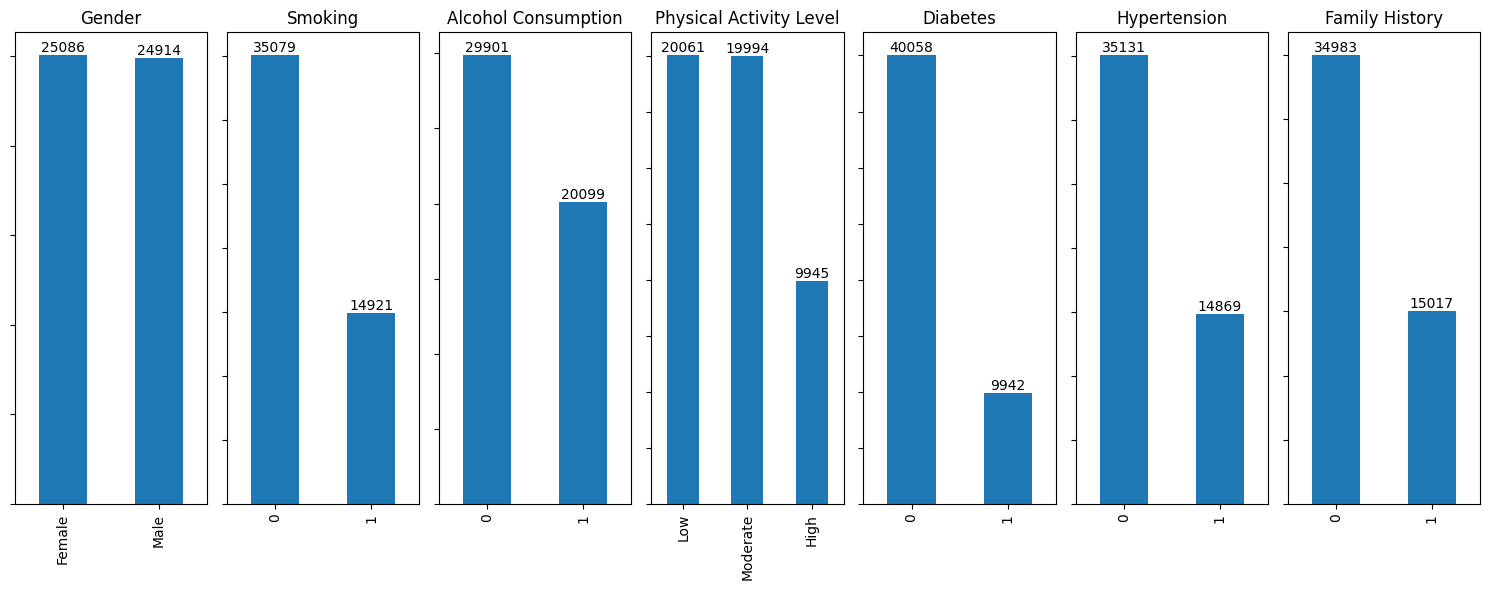

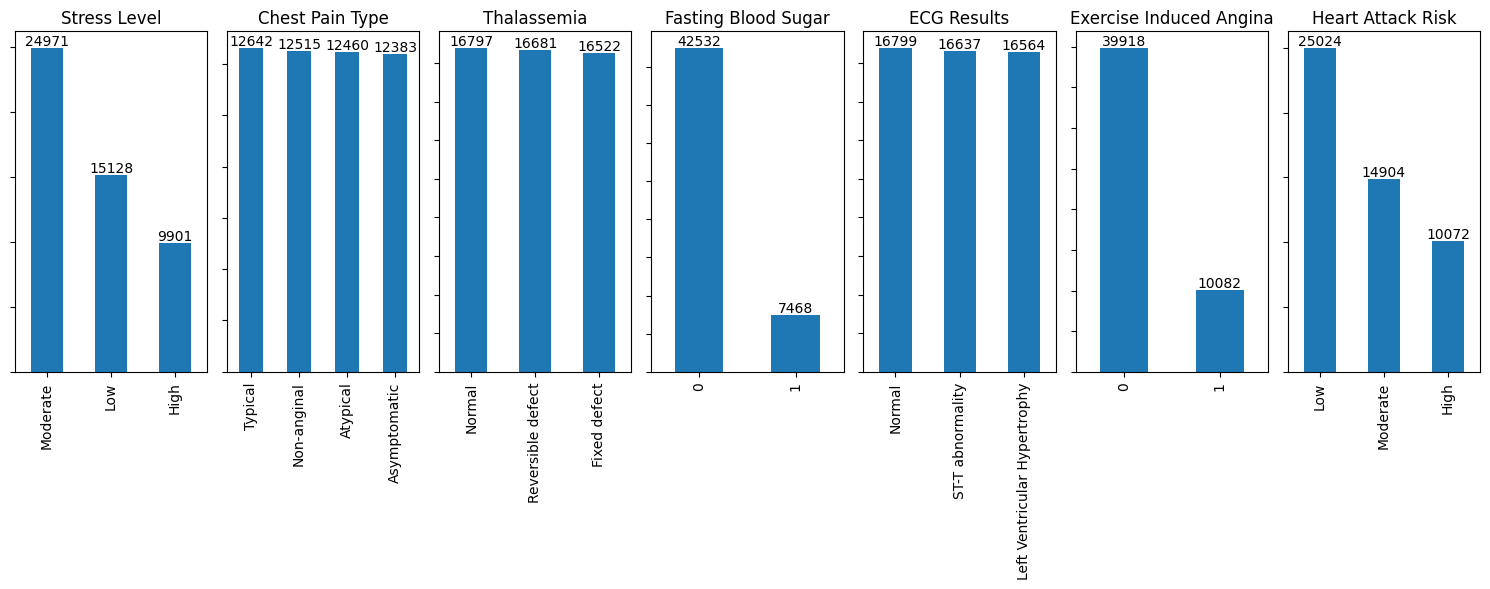

In [116]:
# maak per categorsiche variabeel een bar_plot van de voorkomens van de waarden

def bar_labels(axes, rotation= 0, location="edge"):
    for container in axes.containers:
        axes.bar_label(container, rotation=rotation, label_type=location)
    axes.set_ylabel("")
    axes.set_xlabel("")
    axes.set_yticklabels(())

# plot de categorische waarde af met het voorkomen van de waarde in de dataset
# 14 plots, opgedeeld in 2 rijen met 7 plots

if plot_graphs:
    index = 0
    for r in range(2):
        fig, axes = plt.subplots(ncols=7, figsize=(15, 6))
        for i in range(7):
            df[df_cat_col[index]].value_counts().plot(kind="bar", ax=axes[i])
            bar_labels(axes[i])
            axes[i].set_title(df_cat_col[index].replace('_', ' '))
            
            index+=1      
        plt.tight_layout()   
        save_fig(f"Categorische features value count van de feature deel{r}")
        plt.show()


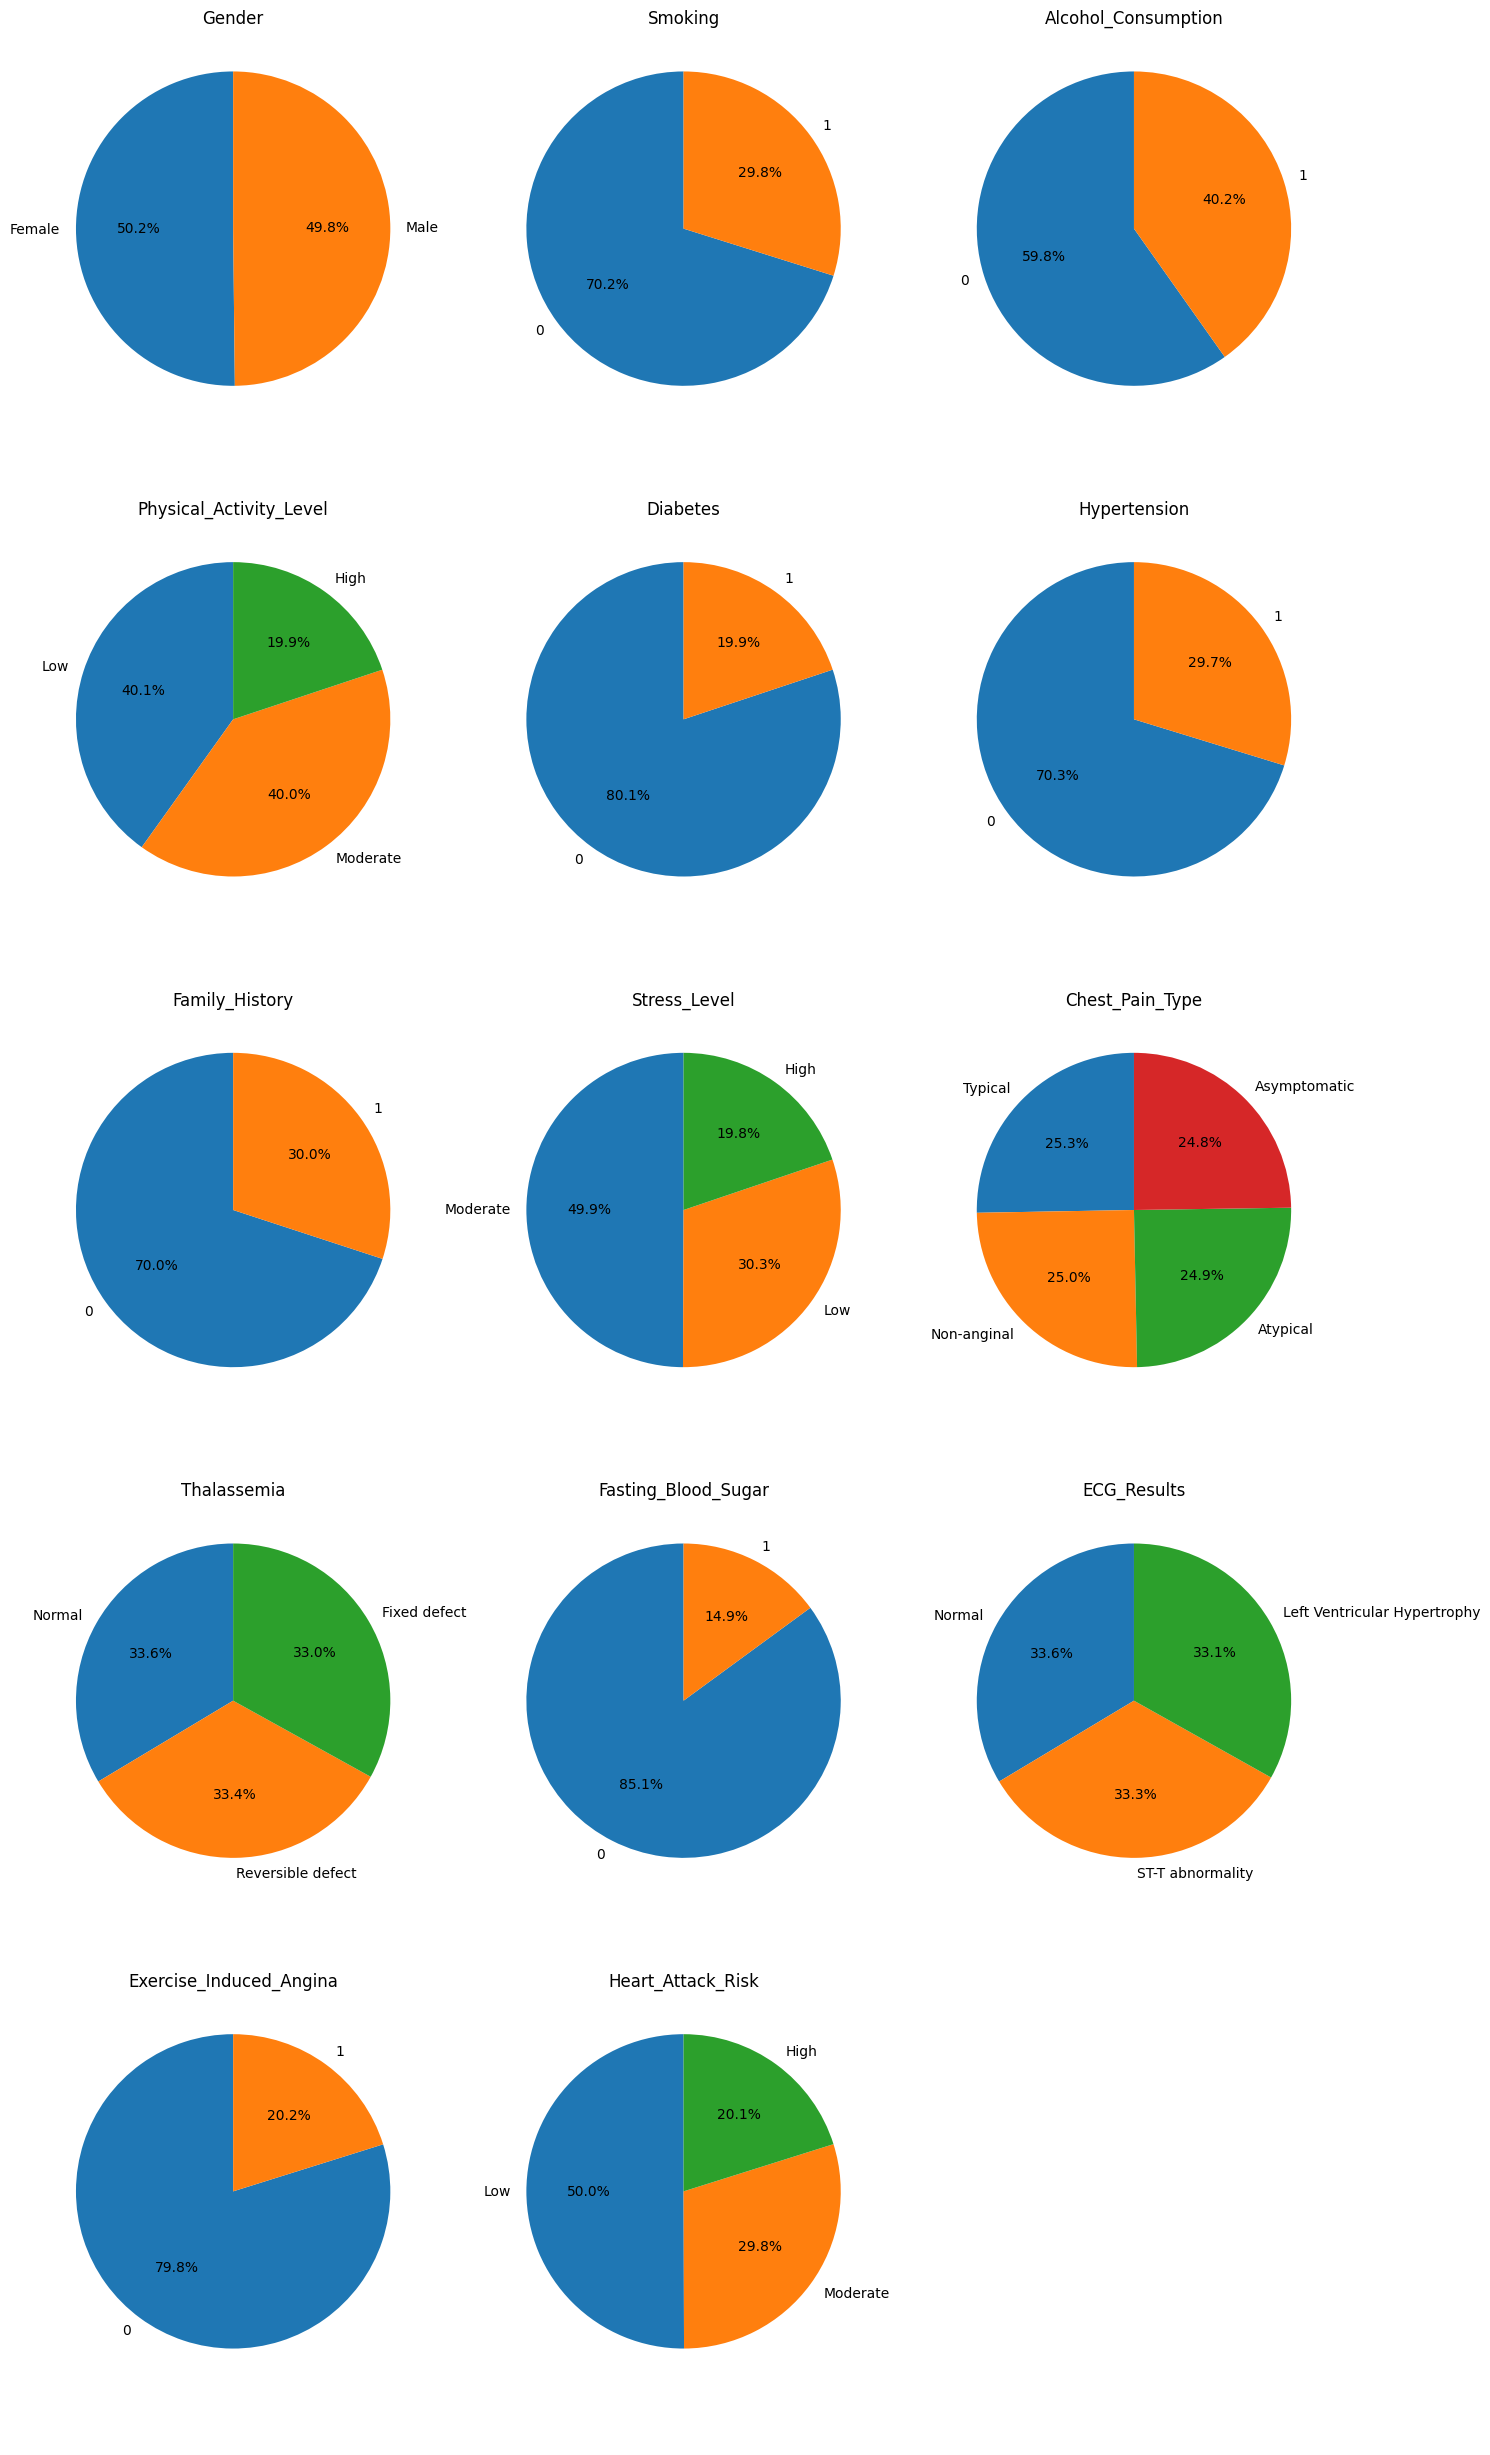

In [117]:
# visuele voorstellen van de unbalance van de categorische variabelen

# Creëer een figuur en een set van subplots

num_columns = 3
num_plots = len(df_cat.columns)
num_rows = (num_plots + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Flatten het axes object voor eenvoudiger iteratie
axes = axes.flatten()

# Loop over alle kolommen en creëer een pie chart voor elke kolom
for i, column in enumerate(df_cat.columns):
    # Haal de waarde tellingen op voor de huidige kolom
    counts = df_cat[column].value_counts()
    
    # Maak een pie chart op de i-th positie in axes
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(column)
    axes[i].set_ylabel('')  # Verwijder de y-label voor netheid

# Verberg eventuele extra subplots als het aantal kolommen minder is dan het aantal subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Toon de plot
plt.tight_layout()
save_fig(f"Categorische features unbalance view")
plt.show()



In [119]:
# SMOTE toepassen

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

# Voorbeeld dataset genereren
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)




# Data in een DataFrame plaatsen voor visualisatie
df_smote = pd.DataFrame(X)
df_smote['target'] = y

# Toon de klasse distributie voor SMOTE
print('Originele dataset shape %s' % Counter(y))

# Pas SMOTE toe
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Toon de nieuwe klasse distributie
print('Resampled dataset shape %s' % Counter(y_res))


from imblearn.under_sampling import RandomUnderSampler

# Toon de originele klasse distributie
print('Originele dataset shape %s' % Counter(y))

# Configureer de RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res_under, y_res_under = rus.fit_resample(X, y)

# Toon de nieuwe klasse distributie
print('Dataset shape na undersampling %s' % Counter(y_res_under))


Originele dataset shape Counter({np.int64(1): 900, np.int64(0): 100})
Resampled dataset shape Counter({np.int64(0): 900, np.int64(1): 900})
Originele dataset shape Counter({np.int64(1): 900, np.int64(0): 100})
Dataset shape na undersampling Counter({np.int64(0): 100, np.int64(1): 100})


In [ ]:
# en nu gaan we op basis van de target value ("Heart risk") groeperen en kijken wat de impact is van de diverse
# categorische variabelen

index = 0

grouped = df.groupby(df_label_col)

# plot 13 grafieken, 
if plot_graphs:
    for j in [5, 4, 4]:
        fig, axes = plt.subplots(ncols=j, figsize=(15, 6))
        for i in range(j):
            grouped[df_cat_col[index]].value_counts().unstack().plot(kind="bar", stacked=True, ax=axes[i])
            bar_labels(axes[i], 0, "center")
            axes[i].set_title(df_cat_col[index].replace('_', ' '))
            index+=1
        plt.tight_layout()
        save_fig(f"Categorische features per value van de target value deel {r}")
        plt.show()

In [ ]:
# we gaan de nominale categorische variabelen omzetten naar een cijfer.
# Via de OneHotEncoding. 
# Voor de feature "Heart risk" doen we een aparte encoding

# print(df_cat.value_counts().sort_values(ascending=False).head(40))


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
ordinal_encoder = OrdinalEncoder()

# hier zouden we kunnen splitsen tussen de nominale categorische waarden en de ordinall
# bv smoking heeft reeds een waarde van 0 en 1, Diabetes
# maar we gaan alle nominale categorische waarden toch via oneHotEncoding transformeren



df_cat_to_encode = df_cat.drop(columns=df_label_col)
cat_encoded = onehot_encoder.fit_transform(df_cat_to_encode)
# dit geeft een numpy arrry terug
cat_encoded


labels = onehot_encoder.get_feature_names_out()
labels.shape
cat_encoded.shape

# print(onehot_encoder.get_feature_names_out())
# print()

# en we moeten daar terug een dataframe van maken
df_cat_encoded = pd.DataFrame(onehot_encoder.transform(df_cat_to_encode),
                        columns=onehot_encoder.get_feature_names_out(),
                        index=df_cat_to_encode.index)

print(df_cat_encoded.head())
print(df_cat_encoded.shape)



In [ ]:
# feature scaling

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
num_min_max_scaled = min_max_scaler.fit_transform(df_num)

df_num_min_max_scaled = pd.DataFrame(num_min_max_scaled,
                        columns=df_num_col,
                        index=df_num.index)


if plot_graphs:
    num_columns = 3
    num_plots = len(df_num_min_max_scaled.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df_num_min_max_scaled.columns):
        df_num_min_max_scaled[column].hist(bins=50, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig("Numercal features na min-max_scaling")
    plt.show()

    plot_histogram(df_num_min_max_scaled,"Age")


In [ ]:
# Laatste stap van de feature preparatie, alles terug samen voegen# 
# de scaled numerische waarde : df_num_min_max_scaled
# de onehot encode categorische waarden : df_cat_encoded

print(df_cat_encoded.head())

X = pd.concat([df_num_min_max_scaled, df_cat_encoded], axis=1)
y = df['Heart_Attack_Risk']

print(X.head())
print(y.head())






In [ ]:
# print histogrammen na feature preparation

plot_graphs = True
if plot_graphs:
    num_plots = len(X.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(X.columns):
        X[column].hist(bins=50, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig("Feature preparation resultaat")
    plt.show()

In [97]:
# voorbereiding voor de data voor de modelering 
# splits de data set op training en test sets
# omwille van de unbalance, voeren we eerst een SMOTE uit 


y = y.map({'Low':0,'Moderate':1,'High':2})

#smote = SMOTE(random_state=0)
#X_sampled, y_sampled = smote.fit_resample(X,y)
X_sampled = X.copy()
y_sampled = y.copy()

# y_train = y_train.map({'Low':1,'Moderate':2,'High':3})
# y_test = y_test.map({'Low':1,'Moderate':2,'High':3})

X_train,X_test,y_train,y_test = train_test_split(X_sampled,y_sampled, test_size=0.2, random_state=42)

In [ ]:
y_test.shape
X_test.shape
y_train.shape
X_train.shape

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def bar_labels(axes, rotation=0, location="edge"):
    for container in axes.containers:
        axes.bar_label(container, rotation=rotation, label_type=location)
    axes.set_ylabel("")
    axes.set_xlabel("")
    axes.set_yticklabels(())

rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
etc = ExtraTreesClassifier()
svc = SVC()
lgr = LogisticRegression()
xgbc = XGBClassifier()
lgbc = LGBMClassifier(verbose=-100)

models_cl = [rfc, abc, gbc, etc,
         lgr, svc, xgbc, lgbc]

names_cl = ["Random Forest", "Ada Boost", "Gradient Boosting", "Extra Trees",
        "Logistic Regression", "Support Vector Machine", "XGBoost", "LightGBM"]



def training_classification():
    scores, reports, cms = [], dict(), dict()

    for i, j in zip(models_cl, names_cl):
        i.fit(X_train, y_train)
        pred = i.predict(X_test)
        scores += [accuracy_score(pred, y_test)*100]
        reports[j] = classification_report(pred, y_test)
        cms[j] = confusion_matrix(pred, y_test)
    fig, axes = plt.subplots()
    dd = pd.DataFrame({"score": scores}, index=names_cl)
    dd = dd.sort_values("score", ascending=False)
    dd["score"] = round(dd["score"], 2)
    dd["score"].plot(kind="bar", ax=axes)
    bar_labels(axes)
    plt.tight_layout()
    plt.show()

    index = 0

    for _ in range(2):
        fig, axes = plt.subplots(ncols=4, figsize=(15, 6))
        for i in range(4):
            sns.heatmap(cms[dd.index[index]], annot=True, fmt='d', ax=axes[i])
            axes[i].set_title("{}: {}%".format(dd.index[index], dd.iloc[index, 0]))
            index += 1
        plt.tight_layout()
        plt.show()

    for i in dd.index:
        print("*"*30)
        print(i)
        print(reports[i])

        print("\n\n")

df = pd.read_csv("data/heart_attack_risk_dataset.csv")

cats = [i for i in df.columns if df[i].nunique() <= 4]
nums = [i for i in df.columns if i not in cats]

index = 0

for _ in range(2):
    fig, axes = plt.subplots(ncols=7, figsize=(15, 6))
    for i in range(7):
        df[cats[index]].value_counts().plot(kind="bar", ax=axes[i])
        bar_labels(axes[i])
        axes[i].set_title(cats[index].replace('_', ' '))
        index+=1
    plt.tight_layout()
    plt.show()





In [ ]:
training_classification()

In [ ]:


# voor een log regression uit
model_logreg= LogisticRegression()
model_logreg.fit(X_train,y_train)

y_pred = model_logreg.predict(X_test)
report = classification_report(y_test, y_pred)

print("\n\n")
print("**********************************")
print("    Logistic regression output"    )
print("**********************************")
print("Classification Report ")
print(report)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


# decision tree model met Optuna 

import optuna

def logistic_regression_optuna(trial): 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    # Suggest hyperparameters
    C = trial.suggest_loguniform('C', 1e-10, 1e10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'saga', 'liblinear'])
    
    # Create and fit the model
    model = LogisticRegression(C=C, solver=solver)
    model.fit(x_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(logistic_regression_optuna, n_trials=100)

print("Best parameters:", study.best_trial.params)
print("Best accuracy:", study.best_trial.value)




# decision tree model
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train,y_train)
y_pred = model_decision_tree.predict(X_test)
report = classification_report(y_test, y_pred)

print("\n\n")
print("**********************************")
print("    Decision Tree Classifier      ")
print("**********************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report ")
print(report)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))




# GridSearch

scoring = { 'accuracy', 'precision', 'recall', 'f1'}

params = {
    'max_depth':[None, 5, 6],
'min_samples_leaf':[1,2, 3],
'min_samples_split':[2,3]
}
gscv_dt = GridSearchCV(model_decision_tree, params, scoring="accuracy", cv=5, refit='f1')
gscv_dt.fit(X_train, y_train)
print("\n\n")
print("**********************************")
print("    Random Forrest Classifier      ")
print("**********************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))








In [107]:
# random forest model
model_random_forest = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=None,    # Maximum depth of the tree (default None for no limit)
    random_state=42,   # Ensures reproducibility
    class_weight='balanced'  # Handles class imbalance
)

model_random_forest.fit(X_train, y_train)
y_pred = model_random_forest.predict(X_test)

# Evaluate the model
print("\n\n")
print("**********************************")
print("    Random Forrest Classifier      ")
print("**********************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


def random_forest_optuna(trial):    
    # Hyperparameters die je wilt optimaliseren
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    # Model creatie
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Cross-validatie gebruiken om modelprestatie te evalueren
    score = cross_val_score(classifier, X, y, n_jobs=-1, cv=3)
    accuracy = np.mean(score)

    return accuracy

# Een studie object creëren die de objective functie maximaliseert
study = optuna.create_study(direction='maximize')
study.optimize(random_forest_optuna, n_trials=100)

print("Beste parameters:", study.best_trial.params)
print("Beste nauwkeurigheid:", study.best_trial.value)



[I 2025-02-06 07:17:03,019] A new study created in memory with name: no-name-e4a8cda5-c907-4e61-b1b8-05f7a8f2c4eb





**********************************
    Random Forrest Classifier      
**********************************
Confusion Matrix:
[[4879  196    8]
 [2829   97    4]
 [1891   92    4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.96      0.66      5083
           1       0.25      0.03      0.06      2930
           2       0.25      0.00      0.00      1987

    accuracy                           0.50     10000
   macro avg       0.34      0.33      0.24     10000
weighted avg       0.38      0.50      0.36     10000


Accuracy Score:
0.498


[I 2025-02-06 07:17:18,272] Trial 0 finished with value: 0.500319999600248 and parameters: {'n_estimators': 237, 'max_depth': 38, 'min_samples_split': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.500319999600248.
[I 2025-02-06 07:17:29,230] Trial 1 finished with value: 0.5004600004003761 and parameters: {'n_estimators': 226, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 11}. Best is trial 1 with value: 0.5004600004003761.
[I 2025-02-06 07:17:37,773] Trial 2 finished with value: 0.500460000400376 and parameters: {'n_estimators': 175, 'max_depth': 48, 'min_samples_split': 20, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.5004600004003761.
[I 2025-02-06 07:17:44,440] Trial 3 finished with value: 0.5004600004003761 and parameters: {'n_estimators': 149, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.5004600004003761.
[I 2025-02-06 07:17:53,194] Trial 4 finished with value: 0.50047999880036 and parameters:

KeyboardInterrupt: 

In [ ]:
# Nu met hyper parameter tuning

# GridSearch

# Create and fit the model Logistic Regression

# Specify scoring metrics
model_logistic_regression = LogisticRegression()

# Specify parameter grid to try
params = {
    'max_iter':[100, 200,500],
    'C':[0.1, 1, 10, 100],
    'fit_intercept':[True]
}

# GridSearchCV met 5 fold cross validation. Use f1 as evaluation metric
gscv_lr = GridSearchCV(model_logistic_regression, params, scoring="precision", cv=5, refit='f1')
gscv_lr.fit(X_train, y_train)
y_pred = gscv_lr.best_estimator_.predict(X_test)

print("************************************")
print("    GridSearch Logistic Regression  ")
print("************************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


In [ ]:
model_decision_tree = DecisionTreeClassifier()
scoring = { 'accuracy', 'precision', 'recall', 'f1'}

params = {
    'max_depth':[None, 5, 6],
    'min_samples_leaf':[1,2, 3],
    'min_samples_split':[2,3]
}

gscv_dt = GridSearchCV(model_decision_tree, params, scoring="accuracy", cv=5, refit='f1')
gscv_dt.fit(X_train, y_train)
y_pred = gscv_dt.best_estimator_.predict(X_test)

print("************************************")
print(" GridSearch Decision Tree Regression")
print("************************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


In [ ]:
model_random_forest = RandomForestClassifier()

params = {
    'max_depth':[None, 5],
'min_samples_leaf':[2],
'min_samples_split':[3],
    'n_estimators':[500]
}

gscv_dt = GridSearchCV(model_random_forest, params, scoring="accuracy", cv=5, refit='f1')
gscv_dt.fit(X_train, y_train)
y_pred = gscv_dt.best_estimator_.predict(X_test)

print("***************************************")
print(" GridSearch Random Forest Regression   ")
print("***************************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def bar_labels(axes, rotation=0, location="edge"):
    for container in axes.containers:
        axes.bar_label(container, rotation=rotation, label_type=location)
    axes.set_ylabel("")
    axes.set_xlabel("")
    axes.set_yticklabels(())

rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
etc = ExtraTreesClassifier()
svc = SVC()
lgr = LogisticRegression()
xgbc = XGBClassifier()
lgbc = LGBMClassifier(verbose=-100)

models_cl = [rfc, abc, gbc, etc,
         lgr, svc, xgbc, lgbc]

names_cl = ["Random Forest", "Ada Boost", "Gradient Boosting", "Extra Trees",
        "Logistic Regression", "Support Vector Machine", "XGBoost", "LightGBM"]



def training_classification():
    scores, reports, cms = [], dict(), dict()

    for i, j in zip(models_cl, names_cl):
        i.fit(X_train, y_train)
        pred = i.predict(X_test)
        scores += [accuracy_score(pred, y_test)*100]
        reports[j] = classification_report(pred, y_test)
        cms[j] = confusion_matrix(pred, y_test)
    fig, axes = plt.subplots()
    dd = pd.DataFrame({"score": scores}, index=names_cl)
    dd = dd.sort_values("score", ascending=False)
    dd["score"] = round(dd["score"], 2)
    dd["score"].plot(kind="bar", ax=axes)
    bar_labels(axes)
    plt.tight_layout()
    plt.show()

    index = 0

    for _ in range(2):
        fig, axes = plt.subplots(ncols=4, figsize=(15, 6))
        for i in range(4):
            sns.heatmap(cms[dd.index[index]], annot=True, fmt='d', ax=axes[i])
            axes[i].set_title("{}: {}%".format(dd.index[index], dd.iloc[index, 0]))
            index += 1
        plt.tight_layout()
        plt.show()

    for i in dd.index:
        print("*"*30)
        print(i)
        print(reports[i])

        print("\n\n")

df = pd.read_csv("data/heart_attack_risk_dataset.csv")

cats = [i for i in df.columns if df[i].nunique() <= 4]
nums = [i for i in df.columns if i not in cats]

index = 0

for _ in range(2):
    fig, axes = plt.subplots(ncols=7, figsize=(15, 6))
    for i in range(7):
        df[cats[index]].value_counts().plot(kind="bar", ax=axes[i])
        bar_labels(axes[i])
        axes[i].set_title(cats[index].replace('_', ' '))
        index+=1
    plt.tight_layout()
    plt.show()

In [ ]:


training_classification()